## Prédiction : qui à survécu

<img src="images/titanic.png">



Ce TP se déroulera donc en plusieurs étapes :
---
**# 1. Chargement des données**

---
**# 2. Nettoyage des données**

---
**# 3. Feature engineering**

---
**# 4. Séparation des données en jeu d'entraînement et de test. _Attention à l'échantillonage, ne pas inclure de biais !_**

---
**# 5. Application d'un modèle [Näive Bayse](https://scikit-learn.org/stable/modules/naive_bayes.html) et évaluation des performances**

---
**# 6. Application d'un modèle [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), affichage de l'arbre et évaluation des performances**

---
**# 7. BONUS : Pour aller plus loin, tentez d'appliquer un nouveau modèle, le [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) et d'évaluer ses résultats par rapports aux deux méthodes précédentes (ne sera pas inclut dans la correction, nous le verrons plus tard sur le même jeu de données**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import requests
import json
# centering figures
from IPython.core.display import HTML
from IPython.display import  Markdown
HTML('<style> .output_png { display: table-cell; text-align: center; vertical-align: middle;}</style>')
display(HTML('<style>.container { width:100% !important; }</style>'))
%matplotlib inline
# my colors
colors= ['#003f5c','#2f4b7c','#665191','#a05195','#d45087','#f95d6a','#ff7c43','#ffa600','#fcca46','#a1c181','#619b8a','#386641']

## 1. Chargement des données

In [2]:
# Chargement le jeu de données titanic.csv à l'aide de la librairie pandas
# Vérification que le chargement s'est bien passé
df = pd.read_csv('data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Affichage des informations de la dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [4]:
# Affichage de la description des champs numériques et catégoriels
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,1309.000000,1309.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,655.000000,0.381971,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,378.020061,0.486055,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


---
## 2. Nettoyage des données

In [5]:
# Remplissage des valeurs nulles de la colonnes Age 
# en permettant de conserver une distribution cohérante des données
df['Age'] = df.groupby(['Sex', 'Pclass']).Age.apply(lambda x: x.fillna(x.median()))


In [6]:
# Remplissage des valeurs nulles de la colonne Embarked avec "S" (Southampton)
df["Embarked"] = df["Embarked"].fillna('S')

In [7]:
# La colonne Fare, remplir les valeurs manquantes par le prix de billet median d'un passager seul de 3eme classe
med_fare = df.groupby(["Pclass", "Parch", "SibSp"]).Fare.median()[3][0][0]
print("Med fare :",med_fare)
df['Fare'] = df['Fare'].fillna(med_fare)


Med fare : 7.8542


In [8]:
# La colonne Cabin : Créeation de la colonne Deck à partir de la première lettre de la colonne Cabin 
# (M signifie Missing: Manquante) 
df['Deck'] = df.Cabin.apply(lambda s: s[0] if pd.notnull(s) else 'M')
# Un peu de nettoyage s'impose : Changement de passager dans le pont T en A
df.loc[df.Deck == 'T', "Deck"] = 'A'
# Meme chose avec un replace : 
# df['Deck'] = df['Deck'].replace('T','A')
# Regroupez les ponts A,B,C en un pont unique ABC, 
# les ponts D et E en DE 
# et les ponts F et G en FG
deck_map = {'A' : 'ABC', 'B' : 'ABC', 'C' : 'ABC',
            'D' : 'DE', 'E' : 'DE',
            'F' : 'FG', 'G' : 'FG',
            'M' : 'M'
}
df.Deck = df.Deck.map(deck_map)


In [9]:
df.Deck

0         M
1       ABC
2         M
3       ABC
4         M
       ... 
1304      M
1305    ABC
1306      M
1307      M
1308      M
Name: Deck, Length: 1309, dtype: object

In [10]:
# La supprition de la colonne Cabin
df.drop('Cabin', axis=1, inplace=True)

In [11]:
# La vérification de l'absence de valeurs nulles
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Deck           0
dtype: int64

---
## 3. Feature engineering

In [12]:
# Créeation d'une variable "Family_Size" à partir des champs SibSp et Parch
df['Family_Size'] = df.SibSp + df.Parch + 1

In [13]:
# Regroupons les familles en groupes : Alone (1), Small (2,3,4), Medium (5,6), Large (7,8,11)
groups = {
    1:'Alone',
    2:'Small', 3:'Small', 4:'Small',
    5:'Medium', 6:'Medium',
    7:'Large', 8:'Large', 11:'Large',
}
df['Family_Size_grouped'] = df.Family_Size.map(groups)

In [14]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Family_Size,Family_Size_grouped
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M,2,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,ABC,2,Small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,1,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,ABC,2,Small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M,1,Alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,25.0,0,0,A.5. 3236,8.0500,S,M,1,Alone
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,ABC,1,Alone
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,M,1,Alone
1307,1308,0,3,"Ware, Mr. Frederick",male,25.0,0,0,359309,8.0500,S,M,1,Alone


In [15]:
# Créeation d'une nouvelle colonne contenant le nombre de passagers partageant le même ticket
df['Ticket_Freq'] = df.groupby('Ticket')['Ticket'].transform('count')

In [ ]:
df

In [16]:
# Extraire le titre du champ Name et les regrouper en employant la méthode vu en cours
df['Title'] = df.Name.str.split(',', expand=True)[1].str.split('.', expand=True)[0]
df['Title'] = df['Title'].replace(['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

In [17]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Family_Size,Family_Size_grouped,Ticket_Freq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M,2,Small,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,ABC,2,Small,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,1,Alone,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,ABC,2,Small,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M,1,Alone,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,25.0,0,0,A.5. 3236,8.0500,S,M,1,Alone,1,Mr
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,ABC,1,Alone,3,Dona
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,M,1,Alone,1,Mr
1307,1308,0,3,"Ware, Mr. Frederick",male,25.0,0,0,359309,8.0500,S,M,1,Alone,1,Mr


In [18]:
#L'encodage des variables catégorielles à l'aide de la fonction pandas get_dummies
df_dummy = pd.get_dummies(df.drop(['Name','Ticket'], axis=1), drop_first=True)
df_dummy.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Ticket_Freq,Sex_male,...,Title_ Master,Title_ Miss,Title_ Mlle,Title_ Mme,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev,Title_ Sir,Title_ the Countess
0,1,0,3,22.0,1,0,7.2500,2,1,1,...,0,0,0,0,1,0,0,0,0,0
1,2,1,1,38.0,1,0,71.2833,2,2,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,3,26.0,0,0,7.9250,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,4,1,1,35.0,1,0,53.1000,2,2,0,...,0,0,0,0,0,1,0,0,0,0
4,5,0,3,35.0,0,0,8.0500,1,1,1,...,0,0,0,0,1,0,0,0,0,0


---
## 4. Train test split

In [19]:
# Créeation d'une copie de mon dataframe
df_clean = df_dummy.copy()

In [20]:
# Spéraration de mon jeu de données en train / test, 70% pour le train, 30% pour le test
from sklearn.model_selection import train_test_split
X = df_dummy.drop(['PassengerId','Survived'], axis=1)
y = df_dummy.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [21]:
# Affichage du taux de survie dans le train et le test pour m'assuré que l'échantillonage
# aléatoire n'a pas introduit de biais dans mes données
print("Taux de survie du train :", y_train.mean())
print("Taux de survie du test :", y_test.mean())

Taux de survie du train : 0.38318777292576417
Taux de survie du test : 0.3791348600508906


---
## 5. Naïve Bayes

In [22]:
# Créeation d'un modèle gaussian naive bayes et entraînement de ce modèle sur mon jeu de données de train
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

GaussianNB()

In [23]:
# Utilisation de la fonction score du modèle pour une première évaluation de la performance sur mon
# jeu de données d'apprentissage (le train)
gaussian.score(X_train, y_train)

0.6834061135371179

In [24]:
# Stockage des résultats de prédiction sur mon jeu de test dans une variable y_pred
y_pred = gaussian.predict(X_test)

In [25]:
# Affichage de la matrice de confusion entre y_pred et y_test
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,239,5
1,119,30


In [26]:
# Affichage des métriques d'évaluation du modèle 
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
print("precision_score :", precision_score(y_test, y_pred))
print("recall_score :", recall_score(y_test, y_pred))
print("accuracy_score :", accuracy_score(y_test, y_pred))
print("f1_score :", f1_score(y_test, y_pred))
print("classification_report :", classification_report(y_test, y_pred))


precision_score : 0.8571428571428571
recall_score : 0.20134228187919462
accuracy_score : 0.6844783715012722
f1_score : 0.3260869565217391
classification_report :               precision    recall  f1-score   support

           0       0.67      0.98      0.79       244
           1       0.86      0.20      0.33       149

    accuracy                           0.68       393
   macro avg       0.76      0.59      0.56       393
weighted avg       0.74      0.68      0.62       393



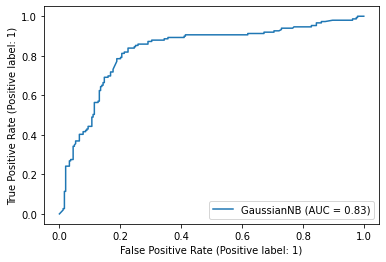

In [27]:
# Affichage la courbe ROC de mon modèle en utilisant la fonction
# plot_roc_curve de la librairie scikit-learn
from sklearn.metrics import plot_roc_curve
plot_roc_curve(gaussian, X_test, y_test)

---
## 6. Application d'un modèle Decision Tree Classifier, affichage de l'arbre et évaluation des performances

In [28]:
# Même chose qu'avec le modèle Naive Bayes mais cette fois-ci avec l'algorithme
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(max_leaf_nodes=6, criterion='gini', random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=6, random_state=42)

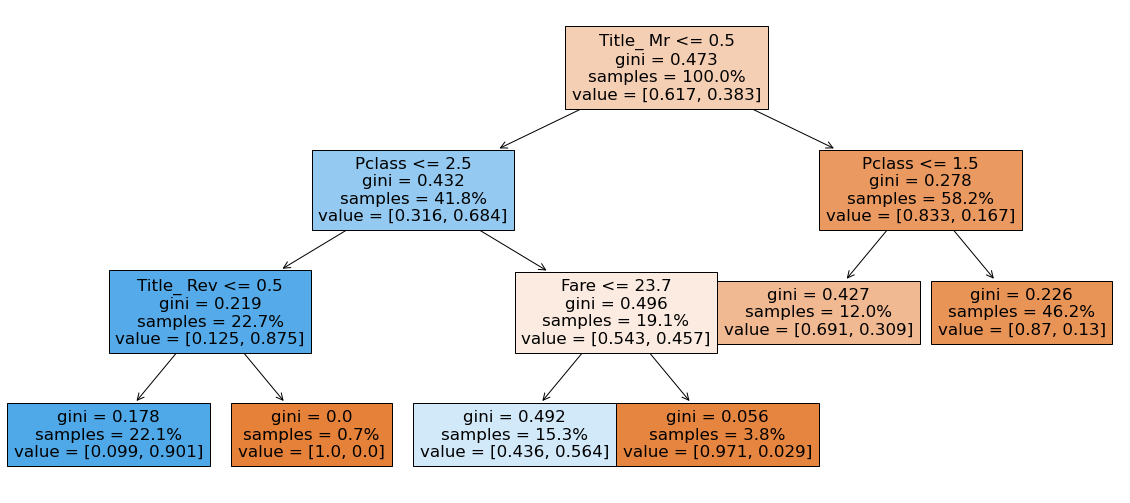

In [29]:
# Affichage de l'arbre de décision obtenu
plt.figure(figsize=(20,9))
plot_tree(clf, feature_names=X.columns, filled=True, proportion=True);

confussion matrix :
      0    1
0  206   38
1   37  112
precision_score : 0.7466666666666667
recall_score : 0.7516778523489933
accuracy_score : 0.8091603053435115
f1_score : 0.7491638795986622
classification_report :               precision    recall  f1-score   support

           0       0.85      0.84      0.85       244
           1       0.75      0.75      0.75       149

    accuracy                           0.81       393
   macro avg       0.80      0.80      0.80       393
weighted avg       0.81      0.81      0.81       393



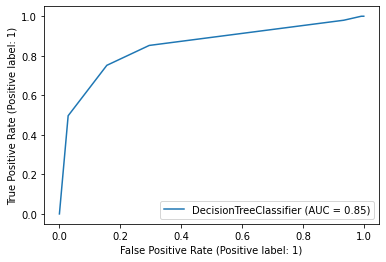

In [30]:
# Affichage de la matrice de confusion, les métriques et la courbe ROC de votre modèle
y_pred = clf.predict(X_test)
print("confussion matrix :\n", pd.DataFrame(confusion_matrix(y_test, y_pred)))
print("precision_score :", precision_score(y_test, y_pred))
print("recall_score :", recall_score(y_test, y_pred))
print("accuracy_score :", accuracy_score(y_test, y_pred))
print("f1_score :", f1_score(y_test, y_pred))
print("classification_report :", classification_report(y_test, y_pred))
plot_roc_curve(clf, X_test, y_test)

#  7. BONUS : Répétez les mêmes étapes en utilisant l'algorithme RandomForestClassifier de Scikit-Learn

Valeurs manquantes après transformation :
 Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          1
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64
Valeurs manquantes après le remplissage :
 Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64


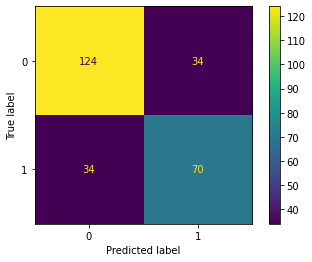

Accuracy: 0.7404580152671756
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78       158
           1       0.67      0.67      0.67       104

    accuracy                           0.74       262
   macro avg       0.73      0.73      0.73       262
weighted avg       0.74      0.74      0.74       262



In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Charger les données Titanic
data = pd.read_csv('data/titanic.csv')

# Supprimer les colonnes non pertinentes
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# Remplir les valeurs manquantes pour 'Age' et 'Embarked'
data['Age'].fillna(data['Age'].mean(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Transformer les variables catégorielles en variables numériques
data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

# Vérifier les valeurs manquantes après transformation
print("Valeurs manquantes après transformation :\n", data.isnull().sum())

# Séparer les caractéristiques (features) de la cible (target)
X = data.drop(columns=['Survived'])
y = data['Survived']


# Vérifier les valeurs manquantes et les remplir par la moyenne de la colonne
if X.isnull().sum().any():
    X.fillna(X.mean(), inplace=True)

# Vérifier les valeurs manquantes après le remplissage
print("Valeurs manquantes après le remplissage :\n", X.isnull().sum())

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédire les valeurs pour l'ensemble de test
y_pred = model.predict(X_test)

# Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Afficher les autres métriques de performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
